## Introduction:

Main Goals:

1. Identify the recipients that will engage with the campaign.
2. Maximise the campaign’s revenue.


Comments

- The dataset contains only 5% of donors.
- The donations are usually smaller than $20.
- This data is quite noisy, high dimensional.
- There is an inverse relationship between the probability to donate and the amount donated.


Link for dataset and some analysis ==> 

https://github.com/rebordao/kdd98cup

https://github.com/bobbyantonio/KDD98/blob/master/CleanData.py

- Siraj notebook for a better data visualization:

https://www.youtube.com/watch?v=yQsOFWqpjkE

In [72]:
import tensorflow as tf
import numpy as np
from sklearn import datasets, linear_model
from tensorflow.python.ops import rnn, rnn_cell
from sklearn.model_selection import train_test_split
from array_split import array_split, shape_split
from sklearn import preprocessing
# from sknn.mlp import Regressor, Layer
import pandas as pd
import random

## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import csv
import sys

import datetime as dt

## warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset:

In [73]:
list_of_lists = []

## works correctly but takes too much running time ..
with open('mailingData_train.txt', 'r') as f:# open the file for reading
    df = []
    for row_num, line in enumerate(f):
        # Remove the new line at the end and then split the string based on
        # tabs. This creates a python list of the values.
        values = line.strip().split(',')
        if row_num == 0: # first line is the header
             header = values
        else:
            df.append([v for v in values])

    df = pd.DataFrame(df)
    df.columns = header
    df.drop(df.index[0], inplace=True)

In [74]:
df = df[0:200] ## to save time .. I gonna work on only 100 records ..

In [75]:
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
1,9401,BOA,1,CA,91326,,,5202,0,,...,0,0,L,2,G,X,X,X,1,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0,1,L,4,E,X,X,X,60,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0,1,L,4,E,X,X,X,41,C
4,8601,,0,FL,33176,,,2001,0,X,...,0,1,L,2,F,X,X,X,26,A
5,9401,CWR,0,AL,35603,,,0,0,,...,0,0,L,1,F,X,X,X,16,C


In [76]:
 np.shape(df)

(200, 481)

In [77]:
df.isnull().any()

ODATEDW     False
OSOURCE     False
TCODE       False
STATE       False
ZIP         False
MAILCODE    False
PVASTATE    False
DOB         False
NOEXCH      False
RECINHSE    False
RECP3       False
RECPGVG     False
RECSWEEP    False
MDMAUD      False
DOMAIN      False
CLUSTER     False
AGE         False
AGEFLAG     False
HOMEOWNR    False
CHILD03     False
CHILD07     False
CHILD12     False
CHILD18     False
NUMCHLD     False
INCOME      False
GENDER      False
WEALTH1     False
HIT         False
MBCRAFT     False
MBGARDEN    False
            ...  
RAMNT_20    False
RAMNT_21    False
RAMNT_22    False
RAMNT_23    False
RAMNT_24    False
RAMNTALL    False
NGIFTALL    False
CARDGIFT    False
MINRAMNT    False
MINRDATE    False
MAXRAMNT    False
MAXRDATE    False
LASTGIFT    False
LASTDATE    False
FISTDATE    False
NEXTDATE    False
TIMELAG     False
AVGGIFT     False
CONTROLN    False
TARGET_B    False
TARGET_D    False
HPHONE_D    False
RFA_2R      False
RFA_2F      False
RFA_2A    

no missing values .. lets double check ..

In [78]:
df.isnull().any().any()

False

In [79]:
df.isnull().sum()

ODATEDW     0
OSOURCE     0
TCODE       0
STATE       0
ZIP         0
MAILCODE    0
PVASTATE    0
DOB         0
NOEXCH      0
RECINHSE    0
RECP3       0
RECPGVG     0
RECSWEEP    0
MDMAUD      0
DOMAIN      0
CLUSTER     0
AGE         0
AGEFLAG     0
HOMEOWNR    0
CHILD03     0
CHILD07     0
CHILD12     0
CHILD18     0
NUMCHLD     0
INCOME      0
GENDER      0
WEALTH1     0
HIT         0
MBCRAFT     0
MBGARDEN    0
           ..
RAMNT_20    0
RAMNT_21    0
RAMNT_22    0
RAMNT_23    0
RAMNT_24    0
RAMNTALL    0
NGIFTALL    0
CARDGIFT    0
MINRAMNT    0
MINRDATE    0
MAXRAMNT    0
MAXRDATE    0
LASTGIFT    0
LASTDATE    0
FISTDATE    0
NEXTDATE    0
TIMELAG     0
AVGGIFT     0
CONTROLN    0
TARGET_B    0
TARGET_D    0
HPHONE_D    0
RFA_2R      0
RFA_2F      0
RFA_2A      0
MDMAUD_R    0
MDMAUD_F    0
MDMAUD_A    0
CLUSTER2    0
GEOCODE2    0
Length: 481, dtype: int64

In [80]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('O'): Index([u'ODATEDW', u'OSOURCE', u'TCODE', u'STATE', u'ZIP', u'MAILCODE',
        u'PVASTATE', u'DOB', u'NOEXCH', u'RECINHSE',
        ...
        u'TARGET_D', u'HPHONE_D', u'RFA_2R', u'RFA_2F', u'RFA_2A', u'MDMAUD_R',
        u'MDMAUD_F', u'MDMAUD_A', u'CLUSTER2', u'GEOCODE2'],
       dtype='object', length=481)}

It is very strange to have a type of categorical data for all variables ..



### Variable distribution

    [1:28] # demographics
    [29:42] # response to other types of mail orders
    [43:55] # overlay data
    [56:74] # donor interests
    [75] # PEP star RFA status
    [76:361] # characteristics of donor neighborhood
    [362:407] # promotion history
    [408:412] # summary variables of promotion history
    [413:456] # giving history
    [457:469] # summary variables of giving history
    [470:473] ## ID & TARGETS
    [474:479] # RFA (recency-frequency-donation amount)
    [480:481] # cluster & geocode

In [81]:
df.describe()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
count,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
unique,11,97,7,36,199,2,2,101,1,2,...,8,2,1,4,4,2,2,2,61,5
top,9501,L01,0,CA,78748,,,0,0,,...,0,1,L,1,F,X,X,X,57,A
freq,39,14,94,31,2,195,198,48,200,183,...,191,102,200,106,91,199,199,199,10,69


## Data Exploration:

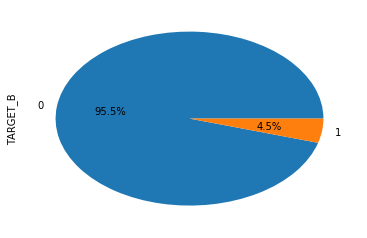

In [82]:
df.TARGET_B.value_counts().plot(x=None, y=None, kind = 'pie', autopct='%1.1f%%')

In [83]:
# % of donors
print 'Percentage of donors: %s' % (100.0 * sum(df.TARGET_B.astype('float'))/df.shape[0])

Percentage of donors: 4.5


about only 5% of the samples are doners .. 

(array([ 7.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   1.        ,   28.14285714,   55.28571429,   82.42857143,
         109.57142857,  136.71428571,  163.85714286,  191.        ]),
 <a list of 7 Patch objects>)

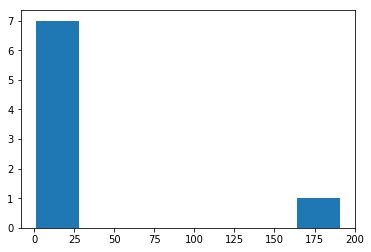

In [84]:
plt.hist(df.TARGET_D.value_counts(), bins = 7)

Histogram is not the best choice .. let's try another plot .. 

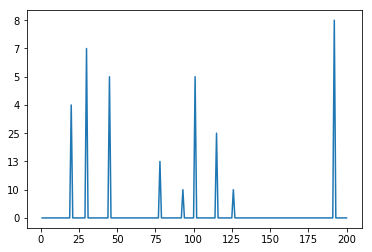

In [85]:
plt.plot(df[df.TARGET_D > 0].TARGET_D)

In [86]:
# % of donors
print 'Percentage of donors: %s' % (100.0 * sum(df.TARGET_D.astype('float'))/df.shape[0])

Percentage of donors: 43.5


about 79% of the continous predictor are doners ..

are there any donation amounts of zero ?!

In [87]:
df.TARGET_D.value_counts()

0     191
5       2
10      2
8       1
7       1
4       1
25      1
13      1
Name: TARGET_D, dtype: int64

In fact .. the majority of the customers donated zero amounts ! .. these are the customer of interest during the analysis .. the goal is to make them donate more .. 

In [88]:
age =  ['AGE901',  'AGE902',  'AGE903',  'AGE904',  'AGE905',  'AGE906',  'AGE907',  'AGEC1',  'AGEC2',  'AGEC3',  'AGEC4',  'AGEC5',  'AGEC6',  'AGEC7']
df[age].head()

,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7
1,34,41,43,32,42,45,32,13,14,33,23,10,4,2
2,35,43,46,37,45,49,23,13,20,19,16,13,10,8
3,32,40,44,34,43,47,25,15,25,17,17,12,7,7
4,33,45,50,36,46,50,27,14,21,13,15,20,12,5
5,32,39,41,33,42,45,27,13,25,24,17,10,6,4


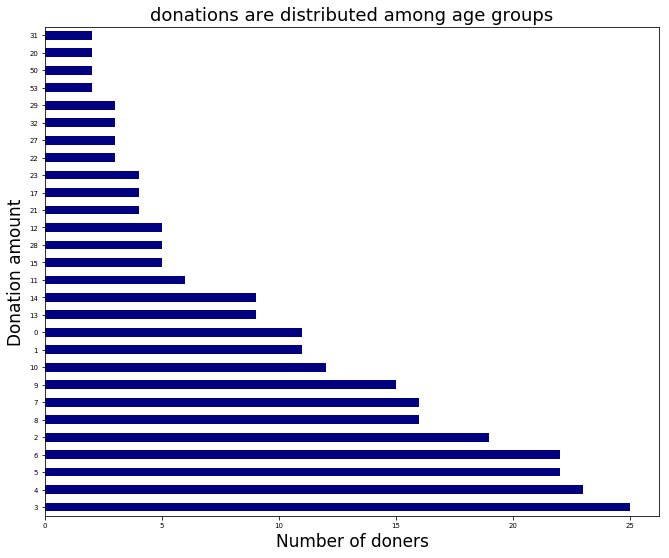

In [89]:
## plotting the rest of variables ..
for i in df[age]:
    df[age][i].value_counts().plot(kind='barh', stacked=True, fontsize=7, figsize=[11,9], colormap='gist_ncar')
    plt.title('donations are distributed among age groups', fontsize=18, color='black') 
    plt.xlabel('Number of doners', fontsize=17, color='black') 
    plt.ylabel('Donation amount', fontsize=17, color='black') 

The majority of the doners donate low amounts and only few of them donate about $200

Text(0,0.5,u'Gender of doner')

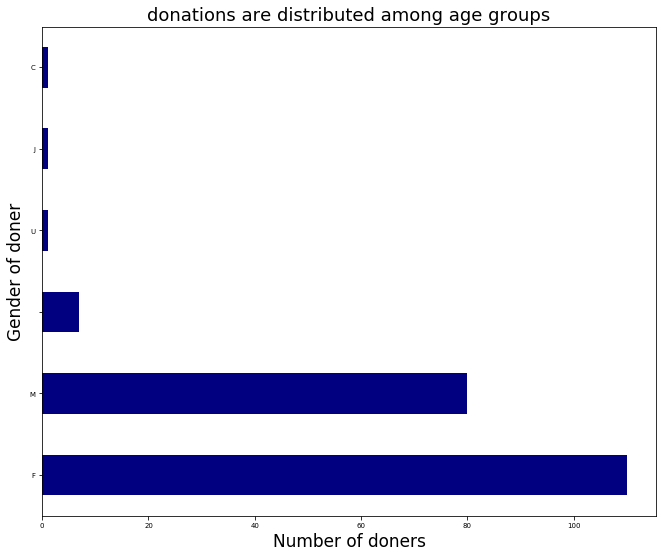

In [90]:
## how donations are distributed per gender

df['GENDER'].value_counts().plot(kind='barh', stacked=True, fontsize=7, figsize=[11,9], colormap='gist_ncar')
plt.title('donations are distributed among age groups', fontsize=18, color='black') 
plt.xlabel('Number of doners', fontsize=17, color='black') 
plt.ylabel('Gender of doner', fontsize=17, color='black') 

In [91]:
df['GENDER'].unique()

array(['M', 'F', ' ', 'C', 'U', 'J'], dtype=object)

It's very strange to have gender rather than M and F !! .. 

Let's impute any other value with the mode of this variable ..

In [92]:
df['GENDER'] = np.where(df['GENDER'] == 'C', df['GENDER'].mode(), df['GENDER'])
df['GENDER'] = np.where(df['GENDER'] == 'U', df['GENDER'].mode(), df['GENDER'])
df['GENDER'] = np.where(df['GENDER'] == 'J', df['GENDER'].mode(), df['GENDER'])
df['GENDER'] = np.where(df['GENDER'] == 'A', df['GENDER'].mode(), df['GENDER'])
df['GENDER'] = np.where(df['GENDER'] == ' ', df['GENDER'].mode(), df['GENDER'])

In [93]:
df['GENDER'].unique()

array(['M', 'F'], dtype=object)

Text(0,0.5,u'Gender of doner')

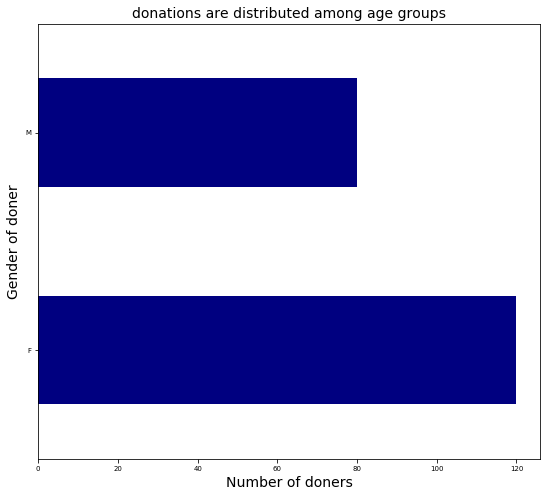

In [94]:
## how donations are distributed per gender

df['GENDER'].value_counts().plot(kind='barh', stacked=True, fontsize=7, figsize=[9,8], colormap='gist_ncar')
plt.title('donations are distributed among age groups', fontsize=14, color='black') 
plt.xlabel('Number of doners', fontsize=14, color='black') 
plt.ylabel('Gender of doner', fontsize=14, color='black') 

The majority of doners are females .. 

## Data Preprocessing:

1. Gets some redundant variables .. by calculating the correlation between all the variables .. 
those of high correlation coeffecient are redundant .. 


In [95]:
df.corr()

""


I think no results appear as all the variables are seen as categorical variables .. not numerical ones ..

__NOTE:__
In this implementation .. 

https://github.com/EAboelhamd/kdd98cup/blob/master/donors.py

They tried to figure out redundant variables to remove them .. to be able to decrease the dimentionality of the problem .. however, in my case, there is no need to do .. as I'm gonna implement deep learning not a shallow solution .. 

In [96]:
df = df[df.columns.difference(['TARGET_B'])]

In [97]:
data = ['ODATEDW','OSOURCE','TCODE','STATE','ZIP','MAILCODE','PVASTATE','DOB','NOEXCH','RECINHSE','RECP3','RECPGVG','RECSWEEP','MDMAUD','DOMAIN','CLUSTER','AGE','AGEFLAG','HOMEOWNR','CHILD03','CHILD07','CHILD12',
  'CHILD18','NUMCHLD','INCOME','GENDER','WEALTH1','HIT','MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML','MAGFEM','MAGMALE',
  'PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP','DATASRCE','MALEMILI','MALEVET','VIETVETS','WWIIVETS','LOCALGOV','STATEGOV','FEDGOV','SOLP3','SOLIH',
  'MAJOR','WEALTH2','GEOCODE','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER','KIDSTUFF','CARDS','PLATES','LIFESRC','PEPSTRFL','POP901','POP902','POP903','POP90C1','POP90C2','POP90C3','POP90C4','POP90C5','ETH1','ETH2','ETH3','ETH4','ETH5','ETH6','ETH7','ETH8','ETH9','ETH10','ETH11','ETH12','ETH13',
  'ETH14','ETH15','ETH16','AGE901','AGE902','AGE903','AGE904','AGE905','AGE906','AGE907','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC3','AGEC4','AGEC5','AGEC6','AGEC7','CHILC1','CHILC2','CHILC3','CHILC4','CHILC5','HHAGE1','HHAGE2','HHAGE3','HHN1','HHN2','HHN3','HHN4','HHN5','HHN6','MARR1','MARR2','MARR3','MARR4','HHP1','HHP2','DW1','DW2','DW3','DW4','DW5','DW6','DW7','DW8','DW9','HV1','HV2','HV3','HV4','HU1','HU2','HU3','HU4','HU5','HHD1',
  'HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8','HHD9','HHD10','HHD11','HHD12','ETHC1','ETHC2','ETHC3','ETHC4','ETHC5','ETHC6','HVP1','HVP2','HVP3','HVP4',
  'HVP5','HVP6','HUR1','HUR2','RHP1','RHP2','RHP3','RHP4','HUPA1','HUPA2','HUPA3','HUPA4','HUPA5','HUPA6',
  'HUPA7','RP1','RP2', 'RP3','RP4','MSA','ADI','DMA','IC1','IC2','IC3','IC4','IC5','IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13','IC14','IC15','IC16','IC17','IC18','IC19','IC20','IC21','IC22','IC23','HHAS1','HHAS2','HHAS3','HHAS4','MC1','MC2','MC3',
  'TPE1','TPE2','TPE3','TPE4','TPE5','TPE6','TPE7','TPE8','TPE9','PEC1','PEC2','TPE10','TPE11','TPE12','TPE13','LFC1','LFC2','LFC3','LFC4','LFC5','LFC6','LFC7','LFC8','LFC9','LFC10','OCC1','OCC2','OCC3','OCC4','OCC5','OCC6','OCC7','OCC8','OCC9',
  'OCC10','OCC11','OCC12','OCC13','EIC1','EIC2','EIC3','EIC4','EIC5','EIC6','EIC7','EIC8','EIC9','EIC10','EIC11','EIC12','EIC13','EIC14','EIC15',
  'EIC16','OEDC1','OEDC2','OEDC3','OEDC4','OEDC5','OEDC6','OEDC7','EC1','EC2','EC3',
  'EC4','EC5','EC6','EC7','EC8','SEC1','SEC2','SEC3','SEC4','SEC5','AFC1','AFC2','AFC3','AFC4','AFC5','AFC6','VC1','VC2','VC3','VC4','ANC1','ANC2','ANC3','ANC4','ANC5','ANC6','ANC7','ANC8','ANC9','ANC10','ANC11','ANC12','ANC13','ANC14','ANC15','POBC1','POBC2','LSC1','LSC2','LSC3','LSC4',
  'VOC1','VOC2', 'VOC3','HC1','HC2','HC3', 'HC4','HC5','HC6','HC7','HC8','HC9','HC10','HC11','HC12','HC13','HC14','HC15','HC16',
  'HC17','HC18','HC19','HC20','HC21','MHUC1','MHUC2','AC1','AC2','ADATE_2','ADATE_3','ADATE_4','ADATE_5','ADATE_6','ADATE_7','ADATE_8','ADATE_9','ADATE_10','ADATE_11','ADATE_12','ADATE_13','ADATE_14','ADATE_15','ADATE_16','ADATE_17','ADATE_18', 'ADATE_19','ADATE_20','ADATE_21','ADATE_22','ADATE_23',
  'ADATE_24','RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12','RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22','RFA_23','RFA_24','CARDPROM','MAXADATE','NUMPROM',
  'CARDPM12', 'NUMPRM12','RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11',
  'RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24','RAMNT_3', 'RAMNT_4','RAMNT_5','RAMNT_6', 'RAMNT_7','RAMNT_8','RAMNT_9', 'RAMNT_10',
  'RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21',
  'RAMNT_22','RAMNT_23','RAMNT_24','RAMNTALL','NGIFTALL','CARDGIFT','MINRAMNT','MINRDATE', 'MAXRAMNT','MAXRDATE','LASTGIFT','LASTDATE','FISTDATE','NEXTDATE','TIMELAG','AVGGIFT','CONTROLN', 'HPHONE_D','RFA_2R','RFA_2F','RFA_2A','MDMAUD_R','MDMAUD_F','MDMAUD_A','CLUSTER2','GEOCODE2']

In [98]:
for i in xrange(len(data)):
    df[data[i]] = pd.Categorical((pd.factorize(df[data[i]])[0] + 1).astype(str))
    
df[data].head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,2,1,2,2,1,1,2,1,1,...,2,2,1,2,2,1,1,1,2,2
3,3,3,2,1,3,1,1,3,1,1,...,3,2,1,2,2,1,1,1,3,2
4,4,4,2,3,4,1,1,4,1,2,...,4,2,1,1,3,1,1,1,4,1
5,1,5,2,4,5,1,1,2,1,1,...,5,1,1,3,3,1,1,1,5,2


In [99]:
train, test = train_test_split(df, test_size = 0.5)  # split data to 50-50 cross validate 

In [100]:
np.shape(train), np.shape(test)

((100, 480), (100, 480))

In [101]:
train.head()

,AC1,AC2,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,...,VETERANS,VIETVETS,VOC1,VOC2,VOC3,WALKER,WEALTH1,WEALTH2,WWIIVETS,ZIP
82,11,14,2,4,2,1,1,1,1,1,...,1,39,8,40,24,1,1,4,41,82
12,1,5,2,1,2,1,1,1,1,2,...,1,8,5,12,8,1,4,3,2,12
15,4,8,3,2,2,1,1,1,1,2,...,1,11,5,14,11,1,1,4,13,15
68,5,14,2,4,3,1,1,1,2,1,...,1,11,5,47,15,1,5,4,17,68
133,14,5,1,1,1,2,2,2,3,2,...,1,27,1,7,14,1,5,4,19,133


## Current State variables ..
Recency, Frequancy, Montery variables .. ['RFA_2R', 'RFA_2F', 'RFA_2A']

## Rewards:
- Donation amount 
- These are the target variables as well .. 
- TARGET_D, TARGET_B 


## Actions: 
- 11 mailing type

Actions mapping .. 
https://github.com/EAboelhamd/kdd98-1/tree/master/notebooks

## States:

In [102]:
## current state ..
RFA = ['RFA_2R', 'RFA_2F', 'RFA_2A']
train[RFA].head()

,RFA_2R,RFA_2F,RFA_2A
82,1,4,2
12,1,2,4
15,1,3,3
68,1,3,1
133,1,3,1


In [103]:
## unique values .. current states 
for i in train[RFA]:
    print train[RFA][i].unique()
    print train[RFA][i].value_counts()

[1]
Categories (1, object): [1]
1    100
Name: RFA_2R, dtype: int64
[4, 2, 3, 1]
Categories (4, object): [4, 2, 3, 1]
3    56
1    17
4    16
2    11
Name: RFA_2F, dtype: int64
[2, 4, 3, 1]
Categories (4, object): [2, 4, 3, 1]
3    50
2    22
1    20
4     8
Name: RFA_2A, dtype: int64


In [104]:
## next states ..
RFA_ = ['RFA_2',  'RFA_3',  'RFA_4',  'RFA_5',  'RFA_6',  'RFA_7',  'RFA_8',  'RFA_9',  'RFA_10',  'RFA_11',  'RFA_12',  'RFA_13',  'RFA_14',  'RFA_15',  'RFA_16',  'RFA_17',  'RFA_18',  'RFA_19',  'RFA_20',  'RFA_21',  'RFA_22',  'RFA_23',  'RFA_24']

train[RFA_].head()

,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,...,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24
82,6,25,26,5,6,12,6,33,2,8,...,1,18,1,29,9,2,2,16,1,3
12,7,9,9,8,9,12,11,10,2,10,...,1,11,9,10,3,3,3,3,1,8
15,4,4,4,5,12,12,14,13,10,13,...,1,1,11,12,1,1,1,1,1,1
68,8,12,12,5,15,31,32,9,2,8,...,1,10,1,1,9,2,2,9,1,3
133,8,10,13,9,10,9,8,8,7,7,...,20,46,40,41,36,30,40,43,22,3


In [105]:
## checked states .. 
RFA__ = ['MDMAUD_R','MDMAUD_F','MDMAUD_A']
train[RFA__].head()

,MDMAUD_R,MDMAUD_F,MDMAUD_A
82,1,1,1
12,1,1,1
15,1,1,1
68,1,1,1
133,1,1,1


In [106]:
## unique values 
for i in train[RFA__]:
    print df[RFA__][i].unique()
    print df[RFA__][i].value_counts()

[1, 2]
Categories (2, object): [1, 2]
1    199
2      1
Name: MDMAUD_R, dtype: int64
[1, 2]
Categories (2, object): [1, 2]
1    199
2      1
Name: MDMAUD_F, dtype: int64
[1, 2]
Categories (2, object): [1, 2]
1    199
2      1
Name: MDMAUD_A, dtype: int64


I'm gonna select the set of variable in a dataframe called (RFA) to represent my current states variables .. as they don't contain X value i.e. missing and interpretable i.e. not in a form of a sequance (S2E) ..

I think (RFA_) might represent the next states varaiables ..

## Rewards:

- Donation amount in dollars (from zero to $1000) ==> continous variable
- Donation flag ==> Binary discrete variable


In [107]:
predictor = ['TARGET_D']
train[predictor].head()

,TARGET_D
82,0
12,0
15,0
68,0
133,0


In [108]:
for i in train[predictor]:
    print train[predictor][i].unique()
    print train[predictor][i].value_counts()

['0' '8' '7' '10' '13' '25']
0     94
10     2
25     1
8      1
7      1
13     1
Name: TARGET_D, dtype: int64


I'm gonna work on TARGET_D variable as it represents continous values and my task is a regression task not a classification one .. 
Let's explore some other variables .. related to donation amounts ..

In [109]:
rewards = ['TARGET_D']

for i in xrange(len(rewards)):
    train[rewards[i]] = pd.Categorical((pd.factorize(train[rewards[i]])[0] + 1).astype(str))
    
train[rewards].head()

,TARGET_D
82,1
12,1
15,1
68,1
133,1


In [111]:
reward_amounts = ['RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15',
  'RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','RAMNTALL']
train[reward_amounts].head()

,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,...,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL
82,1,1,1,1,1,1,2,1,1,3,...,4,1,8,1,1,1,10,1,1,46
12,1,1,1,1,1,4,2,1,1,4,...,8,1,1,1,4,1,1,1,1,12
15,1,1,1,1,1,1,2,2,1,1,...,4,1,1,1,1,1,1,1,1,11
68,1,1,1,1,1,8,2,1,1,1,...,4,1,1,1,1,1,1,1,1,18
133,1,1,1,1,1,1,2,10,1,1,...,4,1,1,13,1,1,1,1,1,34


In [112]:
for i in train[reward_amounts]:
    print (train[reward_amounts][i].value_counts())

1    100
Name: RAMNT_3, dtype: int64
1    100
Name: RAMNT_4, dtype: int64
1    100
Name: RAMNT_5, dtype: int64
1    99
2     1
Name: RAMNT_6, dtype: int64
1     92
5      2
4      2
3      2
8      1
6      1
9      0
7      0
2      0
10     0
Name: RAMNT_7, dtype: int64
1     80
5      5
2      5
3      3
8      2
9      1
7      1
4      1
14     1
13     1
6      0
15     0
12     0
11     0
10     0
Name: RAMNT_8, dtype: int64
2     80
3      5
1      2
6      2
12     2
16     1
11     1
13     1
14     1
15     1
9      1
4      1
5      1
7      1
17     0
8      0
19     0
10     0
18     0
Name: RAMNT_9, dtype: int64
1     91
2      3
6      2
9      1
8      1
5      1
10     1
7      0
4      0
3      0
12     0
11     0
Name: RAMNT_10, dtype: int64
1     91
2      5
7      1
5      1
11     1
10     1
9      0
8      0
6      0
4      0
3      0
Name: RAMNT_11, dtype: int64
1     74
3      7
10     5
5      3
14     2
7      2
6      2
11     2
4      1
12     1
16     1
1

In [113]:
train['RAMNTALL'].describe()

count     100
unique     64
top        46
freq        5
Name: RAMNTALL, dtype: object

## Actions:

- mailing types ..

The following lists the promotion codes and their 
                            respective field names (where XXXX refers to ADATE, RFA, 
                            RDATE and RAMNT.) 
                            
                            '97NK' ==> xxxx_2 (mailing was used to construct 
                                               the target fields)
                            '96NK' ==> xxxx_3
                            '96TK' ==> xxxx_4
                            '96SK' ==> xxxx_5
                            '96LL' ==> xxxx_6
                            '96G1' ==> xxxx_7
                            '96GK' ==> xxxx_8
                            '96CC' ==> xxxx_9
                            '96WL' ==> xxxx_10
                            '96X1' ==> xxxx_11
                            '96XK' ==> xxxx_12
                            '95FS' ==> xxxx_13
                            
                            '95NK' ==> xxxx_14
                            '95TK' ==> xxxx_15
                            '95LL' ==> xxxx_16
                            '95G1' ==> xxxx_17
                            '95GK' ==> xxxx_18
                            '95CC' ==> xxxx_19
                            '95WL' ==> xxxx_20
                            '95X1' ==> xxxx_21
                            '95XK' ==> xxxx_22
                            '94FS' ==> xxxx_23
                            '94NK' ==> xxxx_24

                            1st 2 bytes of the code refers to the year of the 
                            mailing while 3rd and 4th bytes refer to the 
                            following promotion codes/types: 

                            LL mailings had labels only
                            WL mailings had labels only
                            CC mailings are calendars with stickers but do
                               not have labels
                            FS mailings are blank cards that fold into
                               thirds with labels
                            NK mailings are blank cards with labels
                            SK mailings are blank cards with labels
                            TK mailings have thank you printed on the
                               outside with labels
                            GK mailings are general greeting cards (an
                               assortment of birthday, sympathy, blank, & get
                               well) with labels
                            XK mailings are Christmas cards with labels
                            X1 mailings have labels and a notepad
                            G1 mailings have labels and a notepad
        
- This is why I'm gonna extract the last two digits from the sequance to represent mailing type (unique values are 11 .. NK, TK, SK, LL, G1, GK, CC, WL, X1, XK, FS) + no action .. total action are 12

In [114]:
action_mapping = {
    2: 'NK',  3: 'NK',
    4: 'TK',  5: 'SK',
    6: 'LL',  7: 'G1',
    8: 'GK',  9: 'CC',
    10: 'WL', 11: 'X1',
    12: 'XK', 13: 'FS',
    14: 'NK', 15: 'TK',
    16: 'LL', 17: 'G1',
    18: 'GK', 19: 'CC',
    20: 'WL', 21: 'X1',
    22: 'XK', 23: 'FS', 24: 'NK'
}

In [115]:
## actions
actions = ['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14',
  'RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24']

train[actions].head()

,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,...,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24
82,1,1,1,1,1,1,2,1,1,4,...,1,3,1,7,1,1,1,2,1,1
12,1,1,1,1,1,2,2,1,1,4,...,1,4,1,1,1,4,1,1,1,1
15,1,1,1,1,1,1,2,2,1,1,...,1,3,1,1,1,1,1,1,1,1
68,1,1,1,1,1,3,2,1,1,1,...,1,3,1,1,1,1,1,1,1,1
133,1,1,1,1,1,1,2,3,1,1,...,1,3,1,1,2,1,1,1,1,1


In [116]:
train['RDATE_3'].unique()

[1]
Categories (1, object): [1]

In [117]:
## ADATE is the action date .. 

actions_date = ['ADATE_2',  'ADATE_3',  'ADATE_4',  'ADATE_5',  'ADATE_6',  'ADATE_7',  'ADATE_8',  'ADATE_9',  'ADATE_10',  'ADATE_11',
  'ADATE_12',  'ADATE_13',  'ADATE_14',  'ADATE_15',  'ADATE_16',  'ADATE_17',  'ADATE_18',  'ADATE_19',  'ADATE_20',  'ADATE_21',  'ADATE_22',  'ADATE_23',  'ADATE_24']

train[actions_date].head()

,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,...,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24
82,1,1,1,2,1,4,2,3,2,4,...,1,1,1,3,2,2,2,3,1,2
12,1,1,1,1,1,4,1,1,2,1,...,1,1,2,2,1,1,1,1,1,1
15,1,1,1,2,1,4,3,1,3,2,...,1,1,2,3,1,1,1,1,1,1
68,1,1,1,2,1,3,1,2,2,4,...,1,2,1,1,2,2,2,4,1,2
133,1,1,1,1,1,1,1,1,1,1,...,2,3,2,3,1,1,1,1,2,2


In [118]:
current_states = train[RFA]
next_states = train[RFA_]

train[rewards]  ## rewards 

train[actions]  ## actions .. distinct actions are 12

curr_state_current_action = pd.DataFrame(np.column_stack((current_states, train[actions])))

# next actions 
next_actions = np.zeros([len(next_states), max(train[actions].values.max(axis = 0).astype(int)) + 1])
next_actions = np.delete(next_actions, -1, axis=1) ## remove last column .. 

next_state_next_action = np.zeros([np.shape(next_states)[0], np.shape(next_states)[1] + max(train[actions].values.max(axis = 0).astype(int)) ])

# fill in next_actions  
for i in xrange(np.shape(next_actions)[1]):
    next_actions[:, i] = i

Mxa0 = Mxa1 = Mxa2 = Mxa3 = Mxa4 = Mxa5 = Mxa6 =  []

# next_state_next_action
Mxa0 = pd.DataFrame(np.column_stack((next_states, next_actions[:,0])))
Mxa1 = pd.DataFrame(np.column_stack((next_states, next_actions[:,1])))
Mxa2 = pd.DataFrame(np.column_stack((next_states, next_actions[:,2])))
Mxa3 = pd.DataFrame(np.column_stack((next_states, next_actions[:,3])))
Mxa4 = pd.DataFrame(np.column_stack((next_states, next_actions[:,4])))
Mxa5 = pd.DataFrame(np.column_stack((next_states, next_actions[:,5])))
Mxa6 = pd.DataFrame(np.column_stack((next_states, next_actions[:,6])))
# next_state_next_action7 = pd.DataFrame(np.column_stack((next_states, next_actions[:,7])))

tuplesMx = pd.DataFrame(np.column_stack((Mxa0, Mxa1, Mxa2, Mxa3, Mxa4, Mxa5, Mxa6, curr_state_current_action, train[rewards])))
tuplesMx.head()    
# next_state_next_action7

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,6,25,26,5,6,12,6,33,2,8,...,3,1,7,1,1,1,2,1,1,1
1,7,9,9,8,9,12,11,10,2,10,...,4,1,1,1,4,1,1,1,1,1
2,4,4,4,5,12,12,14,13,10,13,...,3,1,1,1,1,1,1,1,1,1
3,8,12,12,5,15,31,32,9,2,8,...,3,1,1,1,1,1,1,1,1,1
4,8,10,13,9,10,9,8,8,7,7,...,3,1,1,2,1,1,1,1,1,1


## Regression phase:

Before performing the prediction task .. let's split the data to training and validation sets .. 

To avoid any problems in prediction by having string variables .. let's binarize (catergorize) all the variables .. 

In [119]:
gamma = 0.9
Num_itrs = 10  # no loop 3leha ( w dah el sa7) .. we just have to run the whole algo. 10 times and report the avg. results

num_epoch = 23 #epochs are cycles of Feedforward and Backprob
## el mafrood yeb2a feh loop 3la el epochs elli heyya el steps .. w avg. reward per step is calculated 
batch_size = 5
chunkSize = 3

n_nodes_hl1 = np.shape(train)[0]
n_nodes_hl2 = np.shape(train)[0]
NUM_STATES = np.shape(train)[1]
NUM_DIM =  np.shape(train)[1]
num_nodes = np.shape(train)[0]
num_unrollings = 5

best_actions = np.zeros([np.shape(train)[0], batch_size])
Q_optimal = [] #np.zeros([np.shape(curr_state_current_action)[0], len(df['ACCOUNT_STATUS'].unique())])
Q_predicted = np.zeros([np.shape(train)[0], max(train[actions].values.max(axis = 0).astype(int))])

In [120]:
## for training 
x = tf.placeholder(tf.float32, shape=[NUM_DIM, num_nodes])
y =  tf.placeholder(tf.float32, shape=[num_nodes, 1])

## for testing
x_ = tf.placeholder(tf.float32, shape=[np.shape(test)[0], NUM_DIM])
y_ =  tf.placeholder(tf.float32, shape=[np.shape(test)[0], 1])
np.shape(y_)

TensorShape([Dimension(100), Dimension(1)])

In [121]:
# Input gate: input, previous output, and bias.
ix = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))# init_weights_RNN([n_nodes_hl1, NUM_ACTIONS])
im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
ib = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Forget gate: input, previous output, and bias.
fx = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
fb = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Memory cell: input, state and bias.                             
cx = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
cb = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Output gate: input, previous output, and bias.
ox = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
ob = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32), trainable=False) #reversed

saved_state = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32), trainable=False) #reversed

# Classifier weights and biases.
w = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
b = tf.Variable(tf.zeros([num_nodes], dtype = tf.float32))

In [122]:
 # Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [123]:
def lstm_model(train, saved_output, saved_state):
    # Unrolled LSTM loop.    
    outputs = list()
    output = saved_output  # row !
    state = saved_state  # row !
    
    # astype('U') .. to convert numpy array to string ..
    for i in xrange(np.shape(train)[0]):## el loop faydetha to copy the next line that is just for single unit 
        output_, state = lstm_cell(tf.string_to_number(train.values[i, None].astype('U')), tf.cast(output, tf.float32), tf.cast(state, tf.float32)) 

    ## in case the last values are saved !
    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        model_output = tf.matmul(output_, w) + b # outputs single value
        
    return model_output  ## the output for the whole model

In [124]:
def train_lstm_model():
    loss_RNN = []
    model_output = lstm_model(train, saved_output, saved_state) #output here is a vector
    model_output = tf.transpose(model_output)
    cost = tf.reduce_mean(tf.square(y - model_output))
    optimize = tf.train.GradientDescentOptimizer(0.01).minimize(cost) 

    sess = tf.Session()
    init = tf.global_variables_initializer()  ## updated version from initialize_all_variables :) 
    sess.run(init)

    predicted_reward = sess.run(model_output, feed_dict={x:np.transpose(train.values), y:train[rewards]})
    
    # Cost calculation
    for step in xrange(1000):
        l,_ = sess.run([cost, optimize], feed_dict={x:np.transpose(train.values), y:train[rewards]})
        
        if step % 100 == 0:
            loss_RNN.append(l)

    Y_pred = tf.zeros([len(test[rewards]),1])

    # predict 
    test_pred2 = sess.run(Y_pred, feed_dict={x_: test.values})

   ## rms to test ..
    cost_test = tf.reduce_mean(tf.square(test[rewards].values.astype(np.float32) - test_pred2))
    
    
    rmse_val = sess.run(cost_test, feed_dict={x_:test.values.astype(np.float32), y_: test_pred2})
    sess.close()
    
    return loss_RNN, predicted_reward #saved_state, saved_output, cost_values

In [125]:
loss_RNN, predicted_reward = train_lstm_model()

In [126]:
# loss_RNN, predicted_reward

Text(0,0.5,u'Prediction Loss')

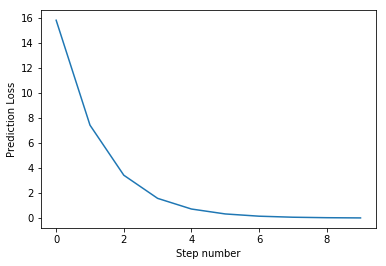

In [127]:
plt.plot(loss_RNN)
plt.xlabel('Step number')
plt.ylabel('Prediction Loss')

## Learning the rewards:
Now, the LSTM_RNN output (from validation phase) is considered as input for DQN model, to be able to select the action that has the maximum longtime reward for the customer (highest CLV) .. 

https://arxiv.org/pdf/1602.01580.pdf

## Multilayer Deep Neural Network (DQN):

https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5_Deep_Q_Network/RL_brain.py

## Model Training:

In [128]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=1))

In [129]:
 # Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [130]:
def DQN_model(X, w_h_1, w_h_2, w_o, bias_I_1, bias_I_2, bias_h):

    layer_1 = tf.matmul(X, w_h_1) + bias_I_1
    layer_1 = tf.nn.relu(layer_1)  ## el performance of softmax outperforms relu!!
    
    layer_2 = tf.matmul(layer_1, w_h_2) + bias_I_2
    layer_2 = tf.nn.sigmoid(layer_2) 

    py_x = tf.matmul(layer_2, w_o) + bias_h
    
    return py_x  #predicted output
    # note that we dont take the softmax at the end because our cost fn does that for us

In [131]:
def DQN_training(X, output):
 
    w_h_1 = init_weights([np.shape(X)[1], n_nodes_hl1]) # create symbolic variables\n",
    w_h_2 = init_weights([n_nodes_hl1, n_nodes_hl2]) # create symbolic variables\n",
    w_o = init_weights([n_nodes_hl2, 1])
    
    bias_I_1=init_weights([n_nodes_hl1])
    bias_I_2=init_weights([n_nodes_hl2])
    bias_h=init_weights([1])
    
    py_x = DQN_model(tf.cast(X, tf.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)  #model training  
        
    cost = tf.reduce_mean(tf.square(py_x - output)) # compute costs",  # excpect float32

    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost) # construct an optimizer\n",
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
#      # Cost calculation
#     for step in xrange(1000):
#         l,_ = sess.run([cost, train_op], feed_dict={x:np.transpose(X), y:np.transpose(output)})
        
#         if step % 100 == 0:
#             loss_RNN.append(l)
            
#     plt.plot(loss_RNN)
    
    sess.close()    
    return w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h

In [132]:
## split dataframe to smaller frames

def splitDataFrameIntoSmaller(df, chunkSize = 3): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    #listOfDf = random.sample(df, chunkSize)  ## in case df is an array not dataframe
    return listOfDf

In [133]:
## Prediction phase: 
def DQN_predict(tuplesMx, output):
    
    Mxa0 = (tuplesMx.iloc[:,0:24]).values 
    Mxa1 = (tuplesMx.iloc[:,25:48]).values
    Mxa2 = (tuplesMx.iloc[:,49:72]).values
    Mxa3 = (tuplesMx.iloc[:,73:96]).values
    Mxa4 = (tuplesMx.iloc[:,97:120]).values
    Mxa5 = (tuplesMx.iloc[:,121:144]).values
    Mxa6 = (tuplesMx.iloc[:,145:168]).values

    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa0, output)
    predict_op_0 = DQN_model(Mxa0.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
      
        
#     print next_state_next_action2     
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa1, output)
    predict_op_1 = DQN_model(Mxa1.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    ## print next_state_next_action3
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa2, output)
    predict_op_2 = DQN_model(Mxa2.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
     
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa3, output)
    predict_op_3 = DQN_model(Mxa3.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
      
        
#     print next_state_next_action4    
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa4, output)
    predict_op_4 = DQN_model(Mxa4.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    ## print next_state_next_action5
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa5, output)
    predict_op_5 = DQN_model(Mxa5.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
     
    ## print next_state_next_action6    
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa6, output)
    predict_op_6 = DQN_model(Mxa6.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)

        
    sess2 = tf.Session()
    init2 = tf.global_variables_initializer()
    sess2.run(init2)

    l0=sess2.run(predict_op_0)
    l1=sess2.run(predict_op_1)
    l2=sess2.run(predict_op_2)
    l3=sess2.run(predict_op_3)
    l4=sess2.run(predict_op_4)
    l5=sess2.run(predict_op_5)
    l6=sess2.run(predict_op_6)
        
    Q_predicted = [l0, l1, l2, l3, l4, l5, l6]
    
    sess2.close()
    return np.transpose(Q_predicted)

Q(s,a) representing the (Quality) of action a at state is .. 

this Q value depends on the immediate reward r .. however, it'll be more effective if it takes the future rewards Q(s', a') into consideration .. 

the future rewards are discounted by probability gama .. cause the evironment is stochastic hence, it is uncertain that each time you select action a you gonna get the same reward r

In [134]:
# predicted_reward = np.transpose(predicted_reward) 

listOfDf = splitDataFrameIntoSmaller(tuplesMx, chunkSize)

for i in xrange(chunkSize):
    for j in xrange(batch_size):
        Q_optimal = predicted_reward[j].astype(float) + gamma*np.max(Q_predicted) # returns max value per row !

        Q_optimal = np.array(Q_optimal, dtype=np.float32) # convert output to float32 to match py_x

        Q_predicted = DQN_predict(listOfDf[i].astype(float), Q_optimal)

    
print("Mean Optimal Q value is:", np.mean(Q_optimal))
# print("Q fun. is: ", Q_predicted) ## CLV

('Mean Optimal Q value is:', 6.0426803)


## Note:

an enhancement for this implementation is to change the states to be the whole doner state instead of just RFM ..

https://github.com/EAboelhamd/kdd98-1/blob/master/notebooks/exploratory.ipynb

Do I apply experience replay .. 

The algorithm is mentioned here .. 

https://www.intelnervana.com/demystifying-deep-reinforcement-learning/